# Statistics and Visualisations

In [1]:
from tools import load_settings
settings = load_settings()
NAME = settings["NAME"]

In [2]:
import pickle
import pandas as pd
from eventstudystatistics import grank, adjBMP
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
# set logging to warning
import logging
logging.getLogger().setLevel(logging.WARNING)
# unpickle the abnormal returns
df_abnormal_returns = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_abnormal_returns.pkl")

# set plotting sizes
tick_size = 15
label_size = 20
title_size = 30
fig_height = 20

EVENT_INDEX = 20 # because 20 [0,..19] are before the event

investigation_periods = {
    "Overall": (pd.Timestamp("2018-01-01"), pd.Timestamp("2021-12-31")),
    "Pre-Pandemic": (pd.Timestamp("2018-01-01"), pd.Timestamp("2020-02-29")),
    "Pandemic": (pd.Timestamp("2020-03-01"), pd.Timestamp("2021-12-31")),
}


CAR_repr = lambda x: str([x[0]-20, x[1]-20])
CAR_periods = {
    "[-20, 20]": np.asarray([0, 40]), # Aussenegg advised to drop this
    "[-20, -1]": np.asarray([0, 19]),
    "[0, 20]": np.asarray([20, 40]),
    "[0, 5]": np.asarray([20, 25]),
    "[0, 1]": np.asarray([20, 21])
}
event_day = 20

with open(f"data/{NAME}/calculate_AR_results/companies.pkl", "rb") as f:
    companies = pickle.load(f)


DEBUG:matplotlib:matplotlib data path: C:\Users\Tom\AppData\Roaming\Python\Python38\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\Tom\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_warnings', '_io', 'marshal', 'nt', '_frozen_importlib_external', '_thread', '_weakref', 'winreg', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', 'encodings.cp1252', '_signal', '__main__', 'encodings.latin_1', '_abc', 'abc', 'io', '_stat', 'stat', '_collections_abc', 'genericpath', 'ntpath', 'os.path', 'os', '_sitebuiltins', '_locale', '_bootlocale', 'types', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib', 'importlib.machinery', 'importlib.abc', '_operator', 'operator', 'keyword', '_heapq', 'heapq', 'itertools', 'reprlib', '_collections', 'collections', '_functools', 'functools', 'cont

### Having a look at all trade types together

In [3]:
types_of_interest = ["P - Purchase", "S - Sale", "S - Sale+OE"]
counts = df_abnormal_returns.groupby(level=2).count()[0].rename({0: "N"})
print(f"relevant filings: ",counts[types_of_interest].sum())
print(counts[types_of_interest])
print(f"dropped filings ", counts.sum() - counts[types_of_interest].sum())

relevant filings:  69214
TradeType
P - Purchase    16429
S - Sale        30506
S - Sale+OE     22279
Name: 0, dtype: int64
dropped filings  210986


In [4]:
# enable multiindex slicing
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)

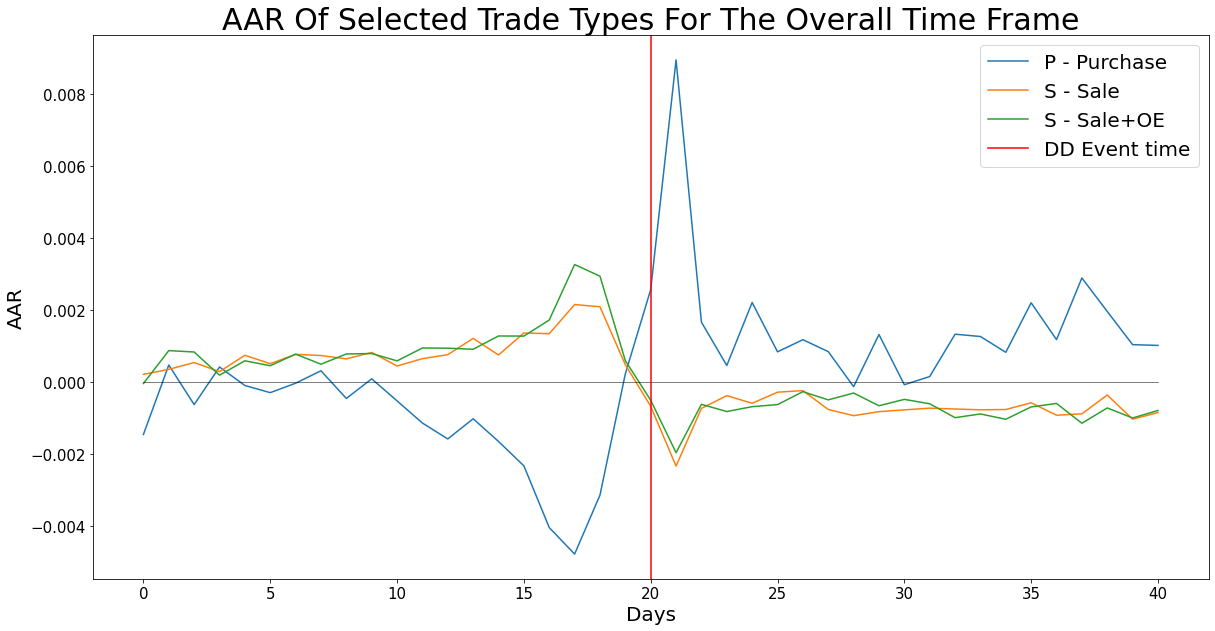

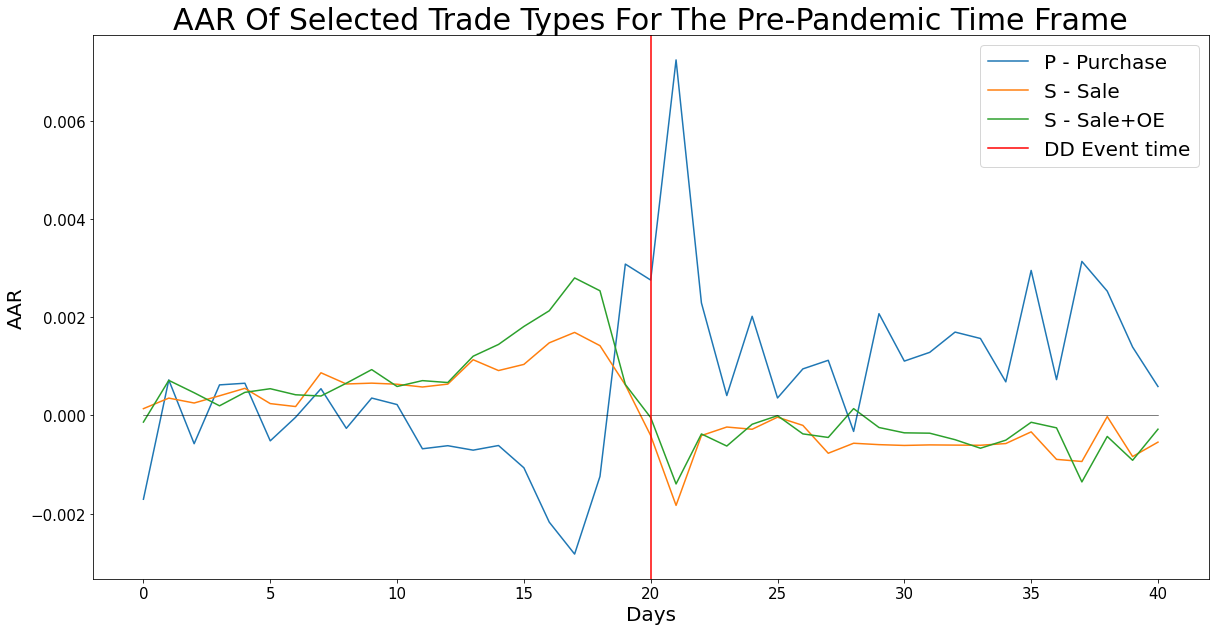

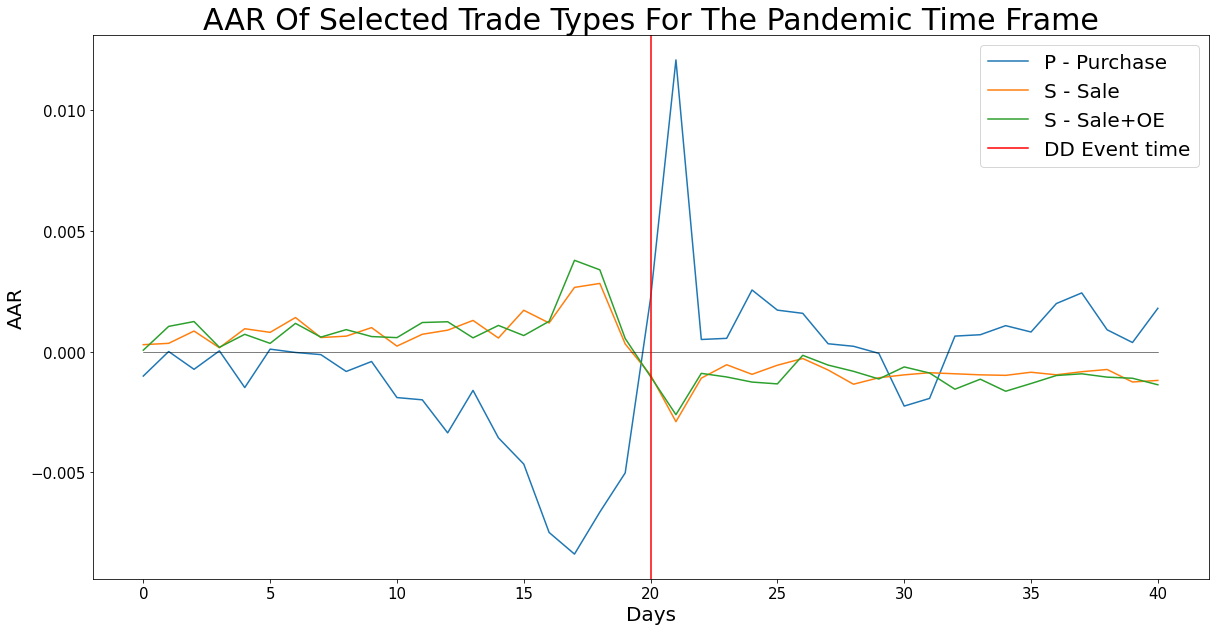

In [5]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"AAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("AAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/AAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

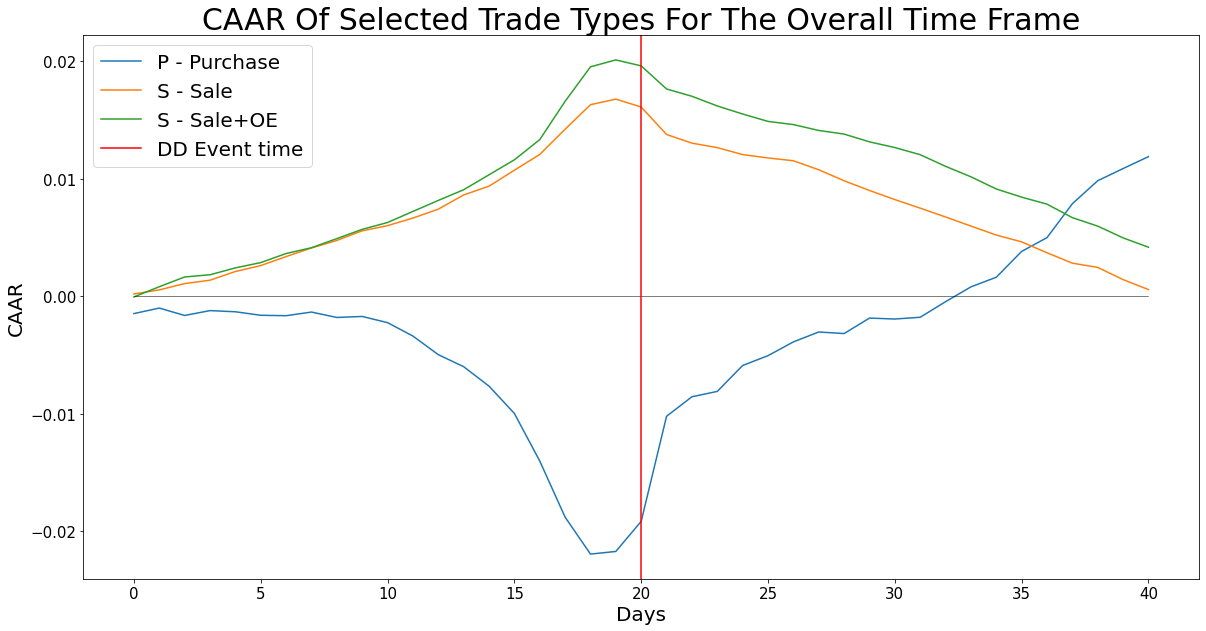

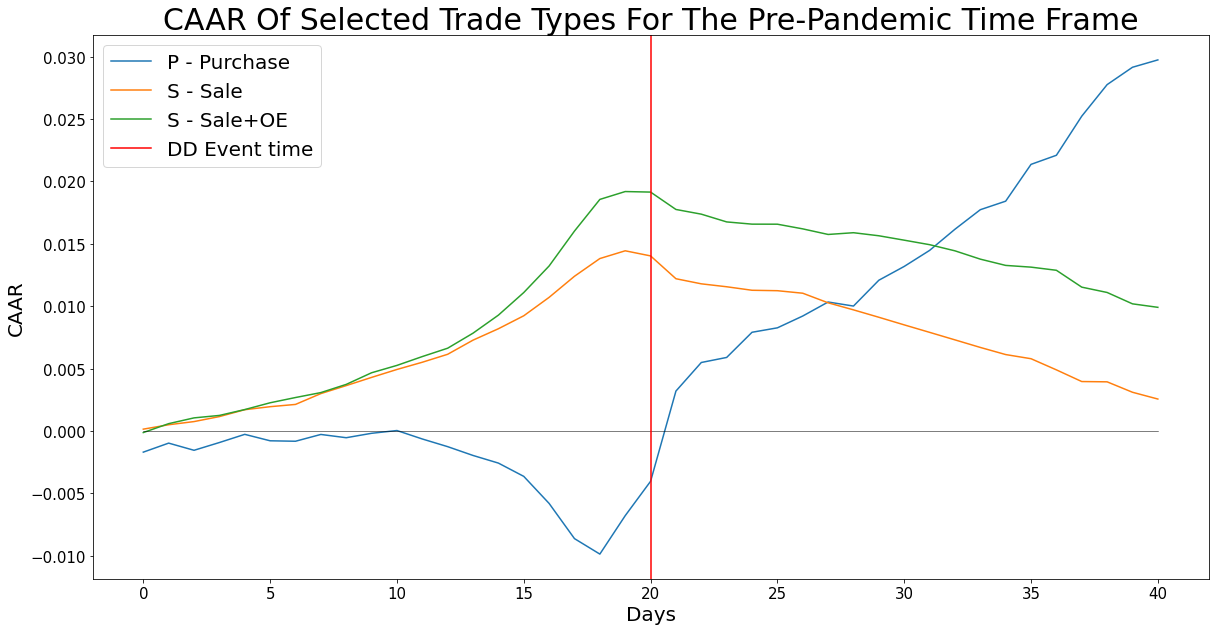

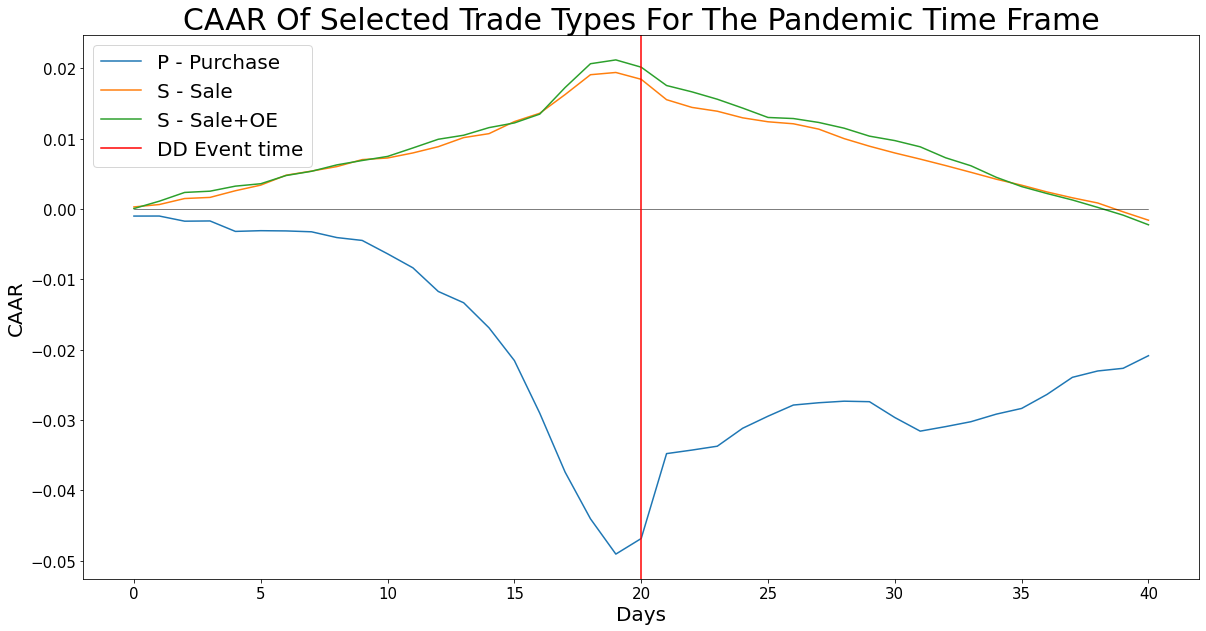

In [6]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).mean().transpose().cumsum().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CAAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CAAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CAAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

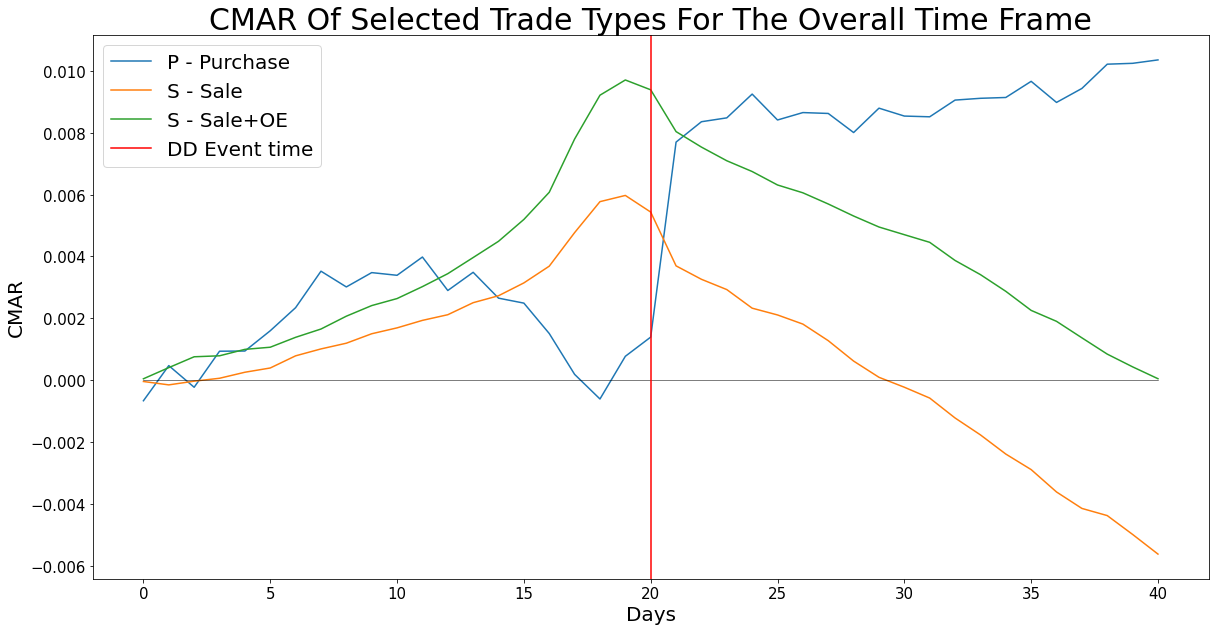

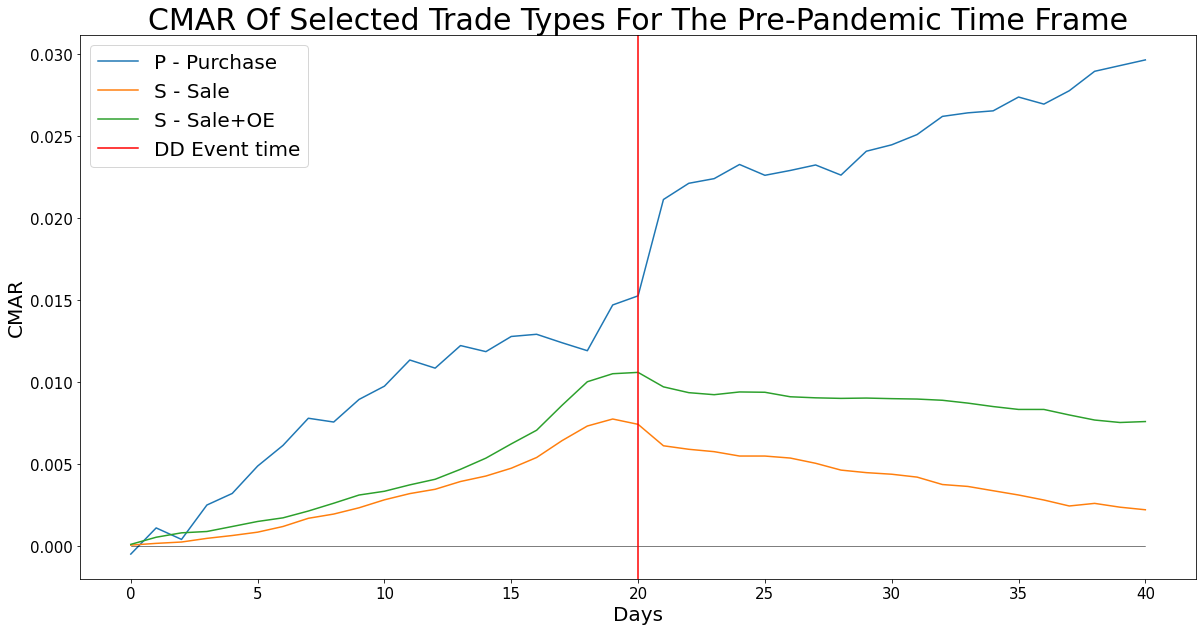

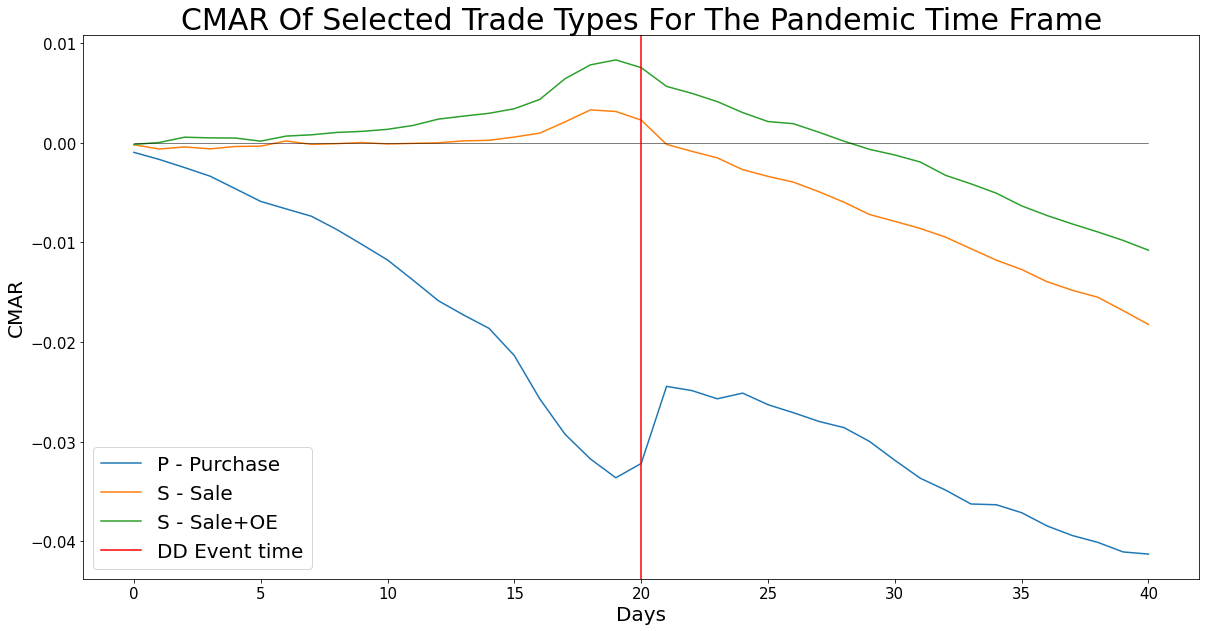

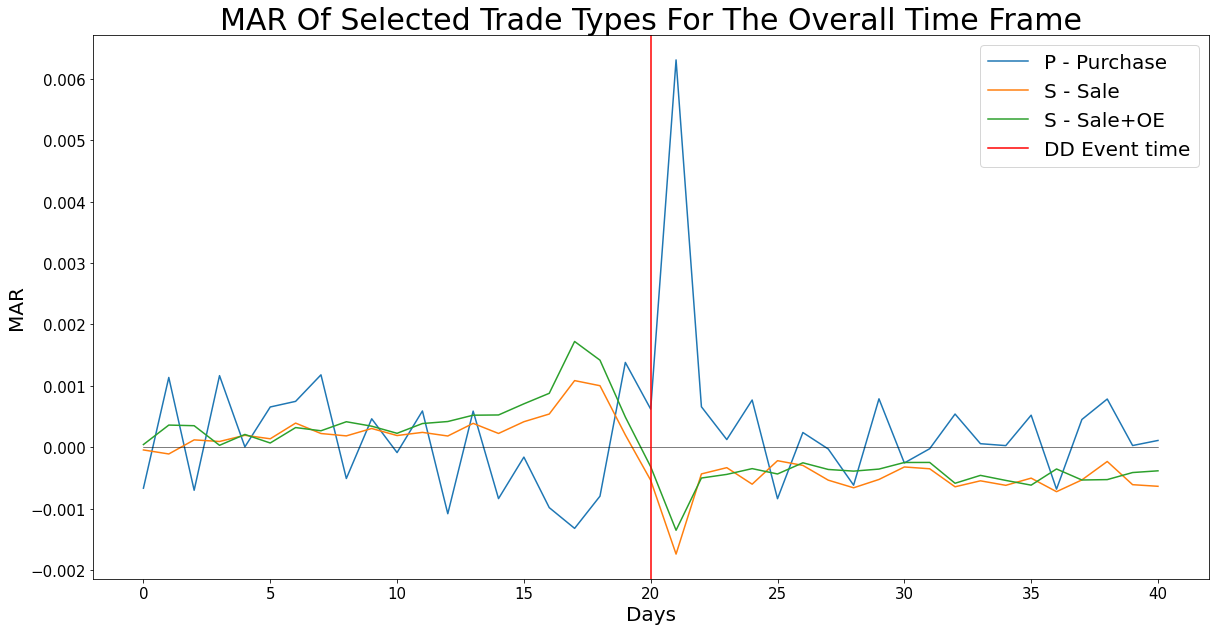

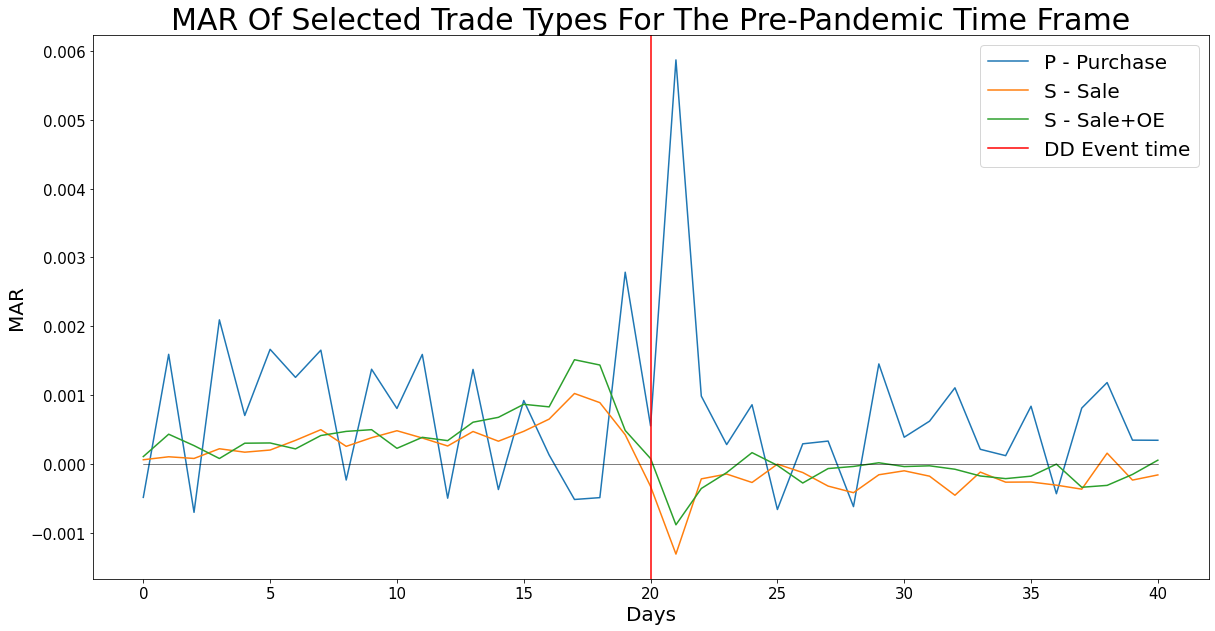

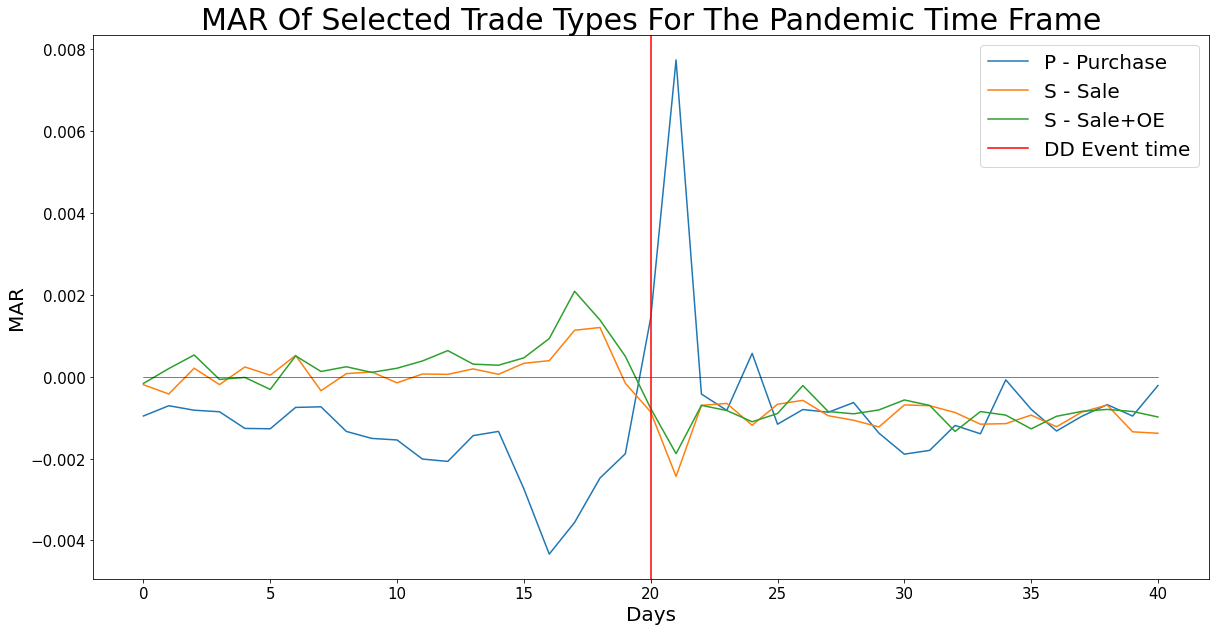

In [7]:
for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().cumsum().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"CMAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("CMAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/CMAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

for investigation_period, (start, end) in investigation_periods.items():
    a = df_abnormal_returns.loc[:,:,types_of_interest,start:end].groupby(level=[2]).median().transpose().plot(figsize=(fig_height, 10))
    plt.plot(np.zeros(len(df_abnormal_returns.columns)), color="black", linewidth=0.5)
    a.set_title(f"MAR Of Selected Trade Types For The {investigation_period} Time Frame",fontsize=title_size)
    a.set_xlabel("Days", fontsize=label_size)
    a.set_ylabel("MAR", fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.yticks(fontsize=tick_size)
    plt.axvline(x = EVENT_INDEX, color = 'red', label = 'DD Event time', linewidth = 1.5)
    plt.legend(fontsize=label_size)
    plt.savefig(f"data/{NAME}/visualisations/MAR_selected_tradetypes_{investigation_period}.png", dpi=600, bbox_inches='tight')

In [8]:
df_abnormal_returns

0         1         2         3   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.012152  0.007386 -0.007207  0.006358   
        3  S - Sale  2021-12-21      -0.009360 -0.052116 -0.013611  0.006317   
        6  G - Gift  2021-12-17       0.005563  0.017338 -0.009051 -0.051981   
        7  S - Sale  2021-12-17       0.005563  0.017338 -0.009051 -0.051981   
        8  S - Sale  2021-12-06      -0.010824  0.026151 -0.007095 -0.001398   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.001355  0.041336  0.032368 -0.021877   
        78 S - Sale  2018-08-16      -0.026529 -0.058754 -0.012507 -0.026825   
        79 S - Sale  2018-08-14      -0.005906 -0.035839 -0.026778 -0.058989   
        80 S - Sale  2018-08-07      -0.019061 -0.001864 -0.002953 -0.002911   
        81 S - Sale  2018-08-03      -0.024830 -0.004142 -0.018787 -0.001851   

                                            4         5         6         7   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30       0.006979  0.014670 -0.007495  0.008109   
        3  S - Sale  2021-12-21       0.005939 -0.005570 -0.012643  0.006108   
        6  G - Gift  2021-12-17      -0.013412  0.007379  0.006076 -0.004588   
        7  S - Sale  2021-12-17      -0.013412  0.007379  0.006076 -0.004588   
        8  S - Sale  2021-12-06      -0.004678  0.010050 -0.019655  0.021602   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.010527 -0.019758  0.006243 -0.012498   
        78 S - Sale  2018-08-16      -0.016524 -0.000368 -0.027301 -0.023253   
        79 S - Sale  2018-08-14      -0.012743 -0.027045 -0.016733 -0.000599   
        80 S - Sale  2018-08-07      -0.016962 -0.004908 -0.034474 -0.027603   
        81 S - Sale  2018-08-03      -0.002612 -0.002683 -0.016777 -0.004645   

                                            8         9   ...        31  \
Company i  TradeType event_timestamp                      ...             
A       2  S - Sale  2021-12-30       0.004208 -0.026409  ... -0.002370   
        3  S - Sale  2021-12-21      -0.007784  0.005237  ...  0.001087   
        6  G - Gift  2021-12-17      -0.012010  0.005649  ... -0.038211   
        7  S - Sale  2021-12-17      -0.012010  0.005649  ... -0.038211   
        8  S - Sale  2021-12-06       0.003414  0.005254  ...  0.013336   
...                                        ...       ...  ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.008881 -0.000438  ...  0.002322   
        78 S - Sale  2018-08-16       0.007529  0.000006  ... -0.010578   
        79 S - Sale  2018-08-14      -0.027548 -0.023495  ...  0.003887   
        80 S - Sale  2018-08-07      -0.058720 -0.012479  ... -0.019499   
        81 S - Sale  2018-08-03      -0.034191 -0.027441  ... -0.041333   

                                            32        33        34        35  \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.021205  0.003561 -0.002202 -0.006005   
        3  S - Sale  2021-12-21      -0.028015  0.000596  0.003662  0.016754   
        6  G - Gift  2021-12-17      -0.010414  0.001256 -0.027784  0.000944   
        7  S - Sale  2021-12-17      -0.010414  0.001256 -0.027784  0.000944   
        8  S - Sale  2021-12-06       0.013480  0.003072 -0.000184  0.002246   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.053708  0.074366 -0.007598 -0.052357   
        78 S - Sale  2018-08-16      -0.041396  0.018974 -0.001984  0.042338   
        79 S - Sale  2018-08-14      -0.005882 -0.010822 -0.041648  0.018736   
        80 S - Sale  2018-08-07      -0.001970 -0.013695  0.006193  0.005659   
        81 S - Sale  2018-

I think OE and OptEx means option exercise. "to exercise" means to put into effect the right to buy or sell the underlying security that is specified in the options contract." Can we be sure that the action does not shift the market, and the swing in return is really due to new information? Are these trades public, so maybe they are used as a signal for traders?

### Boxplot of the sum over all companies's AR

![alt text](assets/images/time_agg.png)

In our case it is not company i, but filing i

Types of trade to pick from:

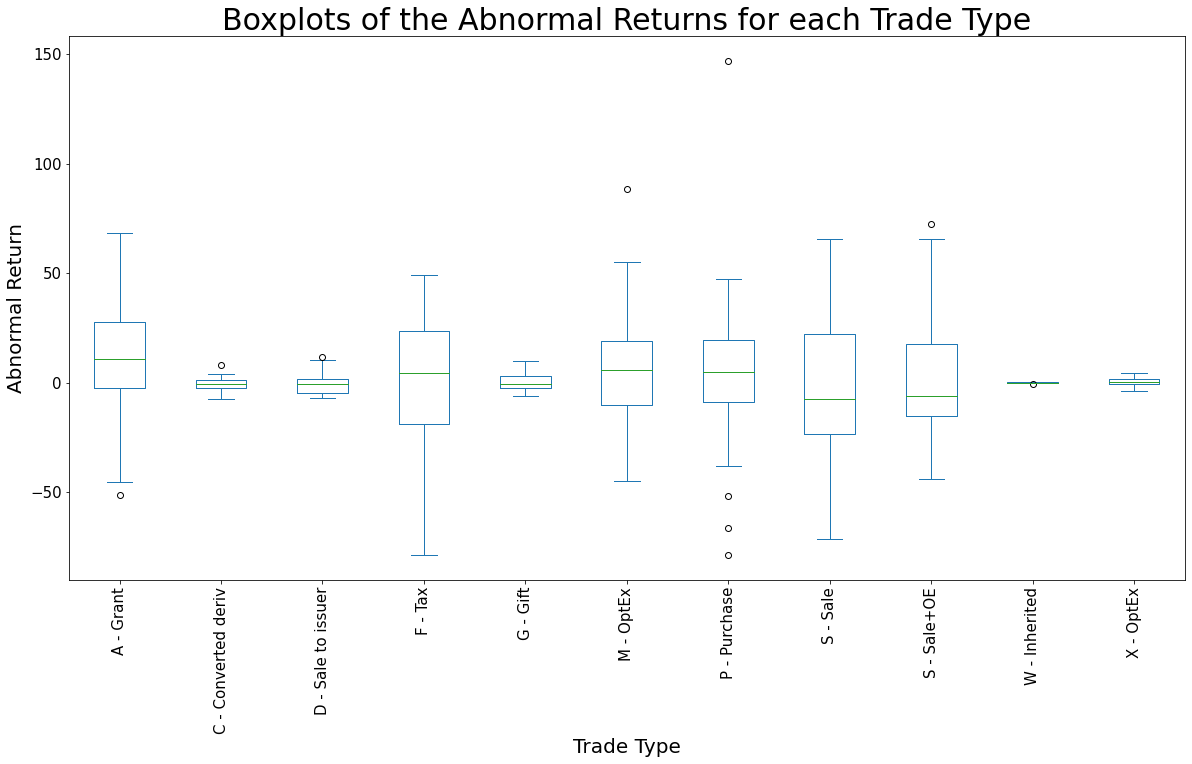

In [9]:
ax = df_abnormal_returns.groupby(level=[2]).sum().transpose().plot.box(rot=90, figsize=(fig_height, 10))
ax.set_title("Boxplots of the Abnormal Returns for each Trade Type",fontsize=title_size)
ax.set_xlabel("Trade Type", fontsize=label_size)
ax.set_ylabel("Abnormal Return", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.savefig(f"data/{NAME}/visualisations/AR_all_tradetypes_boxplot.png", dpi=600, bbox_inches='tight')

In [10]:
types = list(set([x[2] for x in df_abnormal_returns.index]))
types

['A - Grant',
 'P - Purchase',
 'D - Sale to issuer',
 'S - Sale+OE',
 'M - OptEx',
 'X - OptEx',
 'F - Tax',
 'W - Inherited',
 'G - Gift',
 'C - Converted deriv',
 'S - Sale']

Specify the type of the trades to investigate

In [11]:
type_ = "P - Purchase" # "S - Sale"
df_abnormal_returns_type = df_abnormal_returns.loc[:,:,type_]

The index describes the company and the index of the filing in the compnay, the columns represent the days in the event window

In [12]:
df_abnormal_returns_type

0         1         2         3         4   \
Company i   event_timestamp                                                     
AA      85  2021-01-28      -0.009691  0.026533 -0.004668  0.028584 -0.007647   
        96  2020-11-18       0.048303  0.005339 -0.024841  0.009477  0.021854   
        97  2020-10-20      -0.017871  0.000492  0.001662 -0.040046  0.018044   
        111 2020-09-18      -0.005682 -0.043191  0.006080 -0.013762 -0.009739   
        112 2020-08-18       0.018392 -0.015857 -0.021402  0.008227  0.025276   
...                               ...       ...       ...       ...       ...   
ZTS     71  2021-02-23      -0.011247 -0.007338 -0.027405  0.015873 -0.004572   
ZWS     334 2019-02-04      -0.015043 -0.005062  0.001130  0.024848  0.007290   
        344 2018-11-02       0.002474 -0.005742 -0.025981 -0.022245 -0.004582   
ZYME    53  2020-04-07      -0.070580 -0.048124 -0.037611 -0.056025 -0.076347   
        54  2020-01-28      -0.015828 -0.002277  0.006228  0.039188 -0.043007   

                                   5         6         7         8         9   \
Company i   event_timestamp                                                     
AA      85  2021-01-28       0.026128 -0.021591 -0.016989 -0.014880  0.009034   
        96  2020-11-18       0.019131  0.013988  0.024911  0.009131 -0.024158   
        97  2020-10-20      -0.033954 -0.025941 -0.028134  0.031012 -0.033492   
        111 2020-09-18      -0.024002 -0.001233 -0.019893  0.017335 -0.056728   
        112 2020-08-18      -0.018055 -0.003332  0.015975 -0.006281  0.041729   
...                               ...       ...       ...       ...       ...   
ZTS     71  2021-02-23       0.001823  0.005879 -0.015824  0.007827  0.010797   
ZWS     334 2019-02-04      -0.010050 -0.015858 -0.007550 -0.004943  0.004333   
        344 2018-11-02      -0.037544  0.015252  0.006202 -0.027930 -0.022597   
ZYME    53  2020-04-07       0.092469 -0.055240  0.052109  0.043787  0.076722   
        54  2020-01-28      -0.024727  0.025046 -0.015101 -0.006017 -0.034816   

                             ...        31        32        33        34  \
Company i   event_timestamp  ...                                           
AA      85  2021-01-28       ...  0.000560  0.026017 -0.021297 -0.023540   
        96  2020-11-18       ...  0.042893 -0.005761 -0.013322 -0.021939   
        97  2020-10-20       ... -0.068731  0.018846  0.021893  0.010325   
        111 2020-09-18       ... -0.025759 -0.009993  0.013452  0.012795   
        112 2020-08-18       ... -0.049346  0.006079  0.016930  0.015471   
...                          ...       ...       ...       ...       ...   
ZTS     71  2021-02-23       ...  0.001747  0.004471 -0.000592  0.013253   
ZWS     334 2019-02-04       ...  0.003047 -0.003422 -0.004152 -0.005546   
        344 2018-11-02       ... -0.018943  0.002923 -0.000575 -0.005807   
ZYME    53  2020-04-07       ... -0.017925  0.023028 -0.030661 -0.033918   
        54  2020-01-28       ... -0.006797 -0.011712 -0.013153 -0.000979   

                                   35        36        37        38        39  \
Company i   event_timestamp                                                     
AA      85  2021-01-28       0.083143  0.073253 -0.000379  0.065464 -0.016858   
        96  2020-11-18       0.052514 -0.043924 -0.026661 -0.012799 -0.029024   
        97  2020-10-20      -0.004100 -0.011539  0.012518  0.018643  0.022395   
        111 2020-09-18      -0.030474 -0.009488  0.021591  0.027040 -0.057837   
        112 2020-08-18      -0.035472 -0.001631  0.004840 -0.016912 -0.024745   
...                               ...       ...       ...       ...       ...   
ZTS     71  2021-02-23       0.005104  0.005643 -0.018974  0.005845  0.017138   
ZWS     334 2019-02-04      -0.014531 -0.003519 -0.014049  0.008942  0.006323   
        344 2018-11-02      -0.012066 -0.015787  0.007498 -0.001151  0.009052   
ZYME    53  2020-04-07      -0.043735  0.011080

In [13]:
df_abnormal_returns.loc[:,:, types_of_interest].groupby(level=[2]).count()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TradeType,,,,,,,,,,,,,,,,,,,,,
P - Purchase,16429,16429,16429,16429,16429,16429,16429,16429,16429,16429,...,16429,16429,16429,16429,16429,16429,16429,16429,16429,16429
S - Sale,30506,30506,30506,30506,30506,30506,30506,30506,30506,30506,...,30506,30506,30506,30506,30506,30506,30506,30506,30506,30506
S - Sale+OE,22279,22279,22279,22279,22279,22279,22279,22279,22279,22279,...,22279,22279,22279,22279,22279,22279,22279,22279,22279,22279


In [14]:
CAR = df_abnormal_returns.cumsum(axis =1).loc[:,:, types_of_interest]

In [15]:
# aggregate on time axis
CAAR = CAR.groupby(level=[2]).mean().transpose()
print(CAAR.describe().to_latex())

\begin{tabular}{lrrr}
\toprule
TradeType &  P - Purchase &   S - Sale &  S - Sale+OE \\
\midrule
count &     41.000000 &  41.000000 &    41.000000 \\
mean  &     -0.003569 &   0.007422 &     0.009767 \\
std   &      0.007764 &   0.004819 &     0.005670 \\
min   &     -0.021932 &   0.000210 &    -0.000043 \\
25\%   &     -0.005979 &   0.003393 &     0.004983 \\
50\%   &     -0.001843 &   0.006764 &     0.009147 \\
75\%   &     -0.001206 &   0.011549 &     0.014129 \\
max   &      0.011900 &   0.016797 &     0.020134 \\
\bottomrule
\end{tabular}



C:\Users\Tom\AppData\Local\Temp\ipykernel_32712\3958329518.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(CAAR.describe().to_latex())


In [16]:
CAR

0         1         2         3   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.012152 -0.004767 -0.011974 -0.005616   
        3  S - Sale  2021-12-21      -0.009360 -0.061475 -0.075087 -0.068770   
        7  S - Sale  2021-12-17       0.005563  0.022901  0.013850 -0.038131   
        8  S - Sale  2021-12-06      -0.010824  0.015327  0.008232  0.006834   
        10 S - Sale  2021-12-02      -0.001448 -0.004636 -0.015566  0.010480   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31      -0.001355  0.039982  0.072350  0.050473   
        78 S - Sale  2018-08-16      -0.026529 -0.085283 -0.097790 -0.124615   
        79 S - Sale  2018-08-14      -0.005906 -0.041745 -0.068523 -0.127512   
        80 S - Sale  2018-08-07      -0.019061 -0.020925 -0.023878 -0.026789   
        81 S - Sale  2018-08-03      -0.024830 -0.028972 -0.047759 -0.049610   

                                            4         5         6         7   \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30       0.001363  0.016032  0.008537  0.016646   
        3  S - Sale  2021-12-21      -0.062831 -0.068400 -0.081044 -0.074936   
        7  S - Sale  2021-12-17      -0.051543 -0.044164 -0.038088 -0.042676   
        8  S - Sale  2021-12-06       0.002155  0.012205 -0.007450  0.014152   
        10 S - Sale  2021-12-02       0.003265  0.001737 -0.003054  0.006891   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.061000  0.041242  0.047485  0.034987   
        78 S - Sale  2018-08-16      -0.141139 -0.141507 -0.168808 -0.192060   
        79 S - Sale  2018-08-14      -0.140255 -0.167300 -0.184034 -0.184633   
        80 S - Sale  2018-08-07      -0.043752 -0.048660 -0.083133 -0.110736   
        81 S - Sale  2018-08-03      -0.052222 -0.054905 -0.071682 -0.076327   

                                            8         9   ...        31  \
Company i  TradeType event_timestamp                      ...             
A       2  S - Sale  2021-12-30       0.020854 -0.005555  ... -0.072703   
        3  S - Sale  2021-12-21      -0.082720 -0.077483  ... -0.129670   
        7  S - Sale  2021-12-17      -0.054687 -0.049038  ... -0.089872   
        8  S - Sale  2021-12-06       0.017567  0.022821  ... -0.032094   
        10 S - Sale  2021-12-02      -0.012882  0.008606  ... -0.053240   
...                                        ...       ...  ...       ...   
ZYME    77 S - Sale  2018-08-31       0.026106  0.025668  ... -0.032394   
        78 S - Sale  2018-08-16      -0.184531 -0.184525  ... -0.148904   
        79 S - Sale  2018-08-14      -0.212181 -0.235676  ... -0.181457   
        80 S - Sale  2018-08-07      -0.169456 -0.181935  ... -0.210334   
        81 S - Sale  2018-08-03      -0.110518 -0.137959  ... -0.240289   

                                            32        33        34        35  \
Company i  TradeType event_timestamp                                           
A       2  S - Sale  2021-12-30      -0.093908 -0.090347 -0.092549 -0.098554   
        3  S - Sale  2021-12-21      -0.157685 -0.157089 -0.153427 -0.136672   
        7  S - Sale  2021-12-17      -0.100287 -0.099030 -0.126815 -0.125870   
        8  S - Sale  2021-12-06      -0.018614 -0.015542 -0.015727 -0.013481   
        10 S - Sale  2021-12-02      -0.053777 -0.040510 -0.027126 -0.024157   
...                                        ...       ...       ...       ...   
ZYME    77 S - Sale  2018-08-31       0.021314  0.095681  0.088083  0.035726   
        78 S - Sale  2018-08-16      -0.190300 -0.171327 -0.173311 -0.130973   
        79 S - Sale  2018-08-14      -0.187340 -0.198162 -0.239810 -0.221073   
        80 S - Sale  2018-08-07      -0.212304 -0.225999 -0.219806 -0.214147   
        81 S - Sale  2018-

In [17]:
# aggregate on filings axis
results = []
index_stats = []
for type_ in types_of_interest:
    for ip in investigation_periods:
        for cp in CAR_periods:
            l, r = investigation_periods[ip]
            l_CAR, r_CAR = CAR_periods[cp]
            res = CAR.loc[:,:,type_,l:r].iloc[:,l_CAR:(r_CAR+1)].mean(axis=1).groupby(level=[2]).describe().transpose()
            res = res.round(4)
            res.loc["count"] = res.loc["count"].astype(int).astype(str)
            results.append(res.transpose())
            index_stats.append((type_, ip, cp))

In [18]:
stats_df = pd.concat(results)
stats_df.index = pd.MultiIndex.from_tuples(index_stats, names=["Trade Type", "Investigation Period", "CAR period"])
print(stats_df.to_latex())

\begin{tabular}{lllllllllll}
\toprule
            &          &        &  count &    mean &     std &     min &     25\% &     50\% &     75\% &     max \\
Trade Type & Investigation Period & CAR period &        &         &         &         &         &         &         &         \\
\midrule
P - Purchase & Overall & [-20, 20] &  16429 & -0.0036 &  0.1458 & -1.1666 & -0.0684 &  0.0073 &  0.0764 &  1.4009 \\
            &          & [-20, -1] &  16429 & -0.0063 &  0.0912 & -0.8631 & -0.0415 & -0.0033 &  0.0394 &  1.3843 \\
            &          & [0, 20] &  16429 &  -0.001 &  0.2115 & -1.4557 & -0.0976 &  0.0217 &  0.1118 &  1.9569 \\
            &          & [0, 5] &  16429 & -0.0095 &   0.199 & -1.4509 & -0.0933 &  0.0076 &  0.0948 &  1.9762 \\
            &          & [0, 1] &  16429 & -0.0147 &  0.1933 & -1.4492 & -0.0941 &  0.0025 &  0.0857 &  1.9388 \\
            & Pre-Pandemic & [-20, 20] &  10637 &  0.0062 &  0.1219 & -0.7432 & -0.0572 &  0.0146 &  0.0821 &  1.4009 \\
         

C:\Users\Tom\AppData\Local\Temp\ipykernel_32712\1382244739.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df.to_latex())


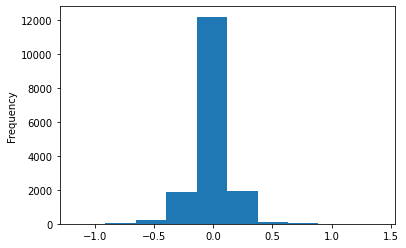

In [19]:
type_ = "P - Purchase"
l,r = investigation_periods["Overall"]
l_CAR, r_CAR = CAR_periods["[-20, 20]"]
CAR.loc[:,:,type_,l:r].iloc[:,l_CAR:(r_CAR+1)].mean(axis=1).plot(kind="hist")
plt.show()

In [20]:
stats_df

count    mean     std     min  \
Trade Type   Investigation Period CAR period                                  
P - Purchase Overall              [-20, 20]   16429 -0.0036  0.1458 -1.1666   
                                  [-20, -1]   16429 -0.0063  0.0912 -0.8631   
                                  [0, 20]     16429  -0.001  0.2115 -1.4557   
                                  [0, 5]      16429 -0.0095   0.199 -1.4509   
                                  [0, 1]      16429 -0.0147  0.1933 -1.4492   
             Pre-Pandemic         [-20, 20]   10637  0.0062  0.1219 -0.7432   
                                  [-20, -1]   10637 -0.0025  0.0793 -0.7313   
                                  [0, 20]     10637  0.0145  0.1726 -1.1796   
                                  [0, 5]      10637  0.0044  0.1559 -1.1191   
                                  [0, 1]      10637 -0.0004  0.1513 -1.1278   
             Pandemic             [-20, 20]    5792 -0.0215  0.1803 -1.1666   
                                  [-20, -1]    5792 -0.0132  0.1093 -0.8631   
                                  [0, 20]      5792 -0.0294  0.2662 -1.4557   
                                  [0, 5]       5792 -0.0351  0.2582 -1.4509   
                                  [0, 1]       5792 -0.0408  0.2508 -1.4492   
S - Sale     Overall              [-20, 20]   30506  0.0074  0.1048 -1.2304   
                                  [-20, -1]   30506  0.0067    0.07 -0.8163   
                                  [0, 20]     30506  0.0081  0.1491 -1.7773   
                                  [0, 5]      30506  0.0132  0.1325 -1.3699   
                                  [0, 1]      30506   0.015  0.1283 -1.2635   
             Pre-Pandemic         [-20, 20]   16035  0.0069  0.0833 -0.6304   
                                  [-20, -1]   16035  0.0056   0.056 -0.4705   
                                  [0, 20]     16035  0.0082  0.1177 -1.1042   
                                  [0, 5]      16035   0.012   0.104 -0.8861   
                                  [0, 1]      16035  0.0131   0.101 -0.8621   
             Pandemic             [-20, 20]   14471   0.008  0.1244 -1.2304   
                                  [-20, -1]   14471   0.008  0.0828 -0.8163   
                                  [0, 20]     14471   0.008  0.1775 -1.7773   
                                  [0, 5]      14471  0.0146  0.1581 -1.3699   
                                  [0, 1]      14471   0.017  0.1529 -1.2635   
S - Sale+OE  Overall              [-20, 20]   22279  0.0098  0.0903 -0.7431   
                                  [-20, -1]   22279  0.0075  0.0592 -0.4216   
                                  [0, 20]     22279  0.0119  0.1293 -1.0493   
                                  [0, 5]      22279  0.0168   0.116 -0.8496   
                                  [0, 1]      22279  0.0186  0.1125 -0.8335   
             Pre-Pandemic         [-20, 20]   11805  0.0108  0.0769  -0.419   
                                  [-20, -1]   11805  0.0067  0.0503 -0.3117   
                                  [0, 20]     11805  0.0147  0.1098 -0.5805   
                                  [0, 5]      11805  0.0174  0.0968  -0.511   
                                  [0, 1]      11805  0.0184  0.0936 -0.4891   
             Pandemic             [-20, 20]   10474  0.0086  0.1034 -0.7431   
                                  [-20, -1]   10474  0.0085  0.0678 -0.4216   
                                  [0, 20]     10474  0.0088  0.1481 -1.0493   
                                  [0, 5]      10474  0.0162  0.1344 -0.8496   
                                  [0, 1]      10474  0.0189  0.1306 -0.8335   

                                                 25%     50%     75%     max  
Trade Type   Investigation Period CAR period                                  
P - Purchase Overall              [-20, 20]  -0.0684  0.0073  0.0764  1.4009  
                                  [-20, -1]  -0.0415 -0.0033  0.0394  1.3843  
                

In [21]:
for ip in investigation_periods:
    l, r = investigation_periods[ip]
    l_CAR, r_CAR = CAR_periods[cp]
    res = CAR.loc[:,:,type_,l:r].iloc[:,l_CAR:(l_CAR+1)].mean(axis=1).groupby(level=[2]).describe().transpose()

# Statistics

Check if CAR mean = 0 (t-test)

In [22]:
# unpickle the data
df_eps = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_eps.pkl")
df_estimation_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_estimation_window_market_return.pkl")
df_event_window_market_return = pd.read_pickle(f"data/{NAME}/calculate_AR_results/df_event_window_market_return.pkl")

df_eps.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_estimation_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
df_event_window_market_return.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)


In [23]:
df_abnormal_returns.sort_index(level=["Company", "i", "TradeType", "event_timestamp"], ascending=True, inplace=True)
left, right = investigation_periods["Pandemic"]
df_abnormal_returns.loc[:,:,type_, left:right]

0         1         2   \
Company i   TradeType    event_timestamp                                 
AA      85  P - Purchase 2021-01-28      -0.009691  0.026533 -0.004668   
        96  P - Purchase 2020-11-18       0.048303  0.005339 -0.024841   
        97  P - Purchase 2020-10-20      -0.017871  0.000492  0.001662   
        111 P - Purchase 2020-09-18      -0.005682 -0.043191  0.006080   
        112 P - Purchase 2020-08-18       0.018392 -0.015857 -0.021402   
...                                            ...       ...       ...   
YETI    140 P - Purchase 2020-05-12       0.137251 -0.015499  0.016894   
ZBH     12  P - Purchase 2021-05-10      -0.007833  0.001889 -0.003115   
        39  P - Purchase 2020-05-13      -0.003231 -0.004603  0.052125   
ZTS     71  P - Purchase 2021-02-23      -0.011247 -0.007338 -0.027405   
ZYME    53  P - Purchase 2020-04-07      -0.070580 -0.048124 -0.037611   

                                                3         4         5   \
Company i   TradeType    event_timestamp                                 
AA      85  P - Purchase 2021-01-28       0.028584 -0.007647  0.026128   
        96  P - Purchase 2020-11-18       0.009477  0.021854  0.019131   
        97  P - Purchase 2020-10-20      -0.040046  0.018044 -0.033954   
        111 P - Purchase 2020-09-18      -0.013762 -0.009739 -0.024002   
        112 P - Purchase 2020-08-18       0.008227  0.025276 -0.018055   
...                                            ...       ...       ...   
YETI    140 P - Purchase 2020-05-12      -0.064394  0.007701 -0.006162   
ZBH     12  P - Purchase 2021-05-10       0.013755 -0.003156  0.008556   
        39  P - Purchase 2020-05-13       0.003844 -0.016423 -0.042547   
ZTS     71  P - Purchase 2021-02-23       0.015873 -0.004572  0.001823   
ZYME    53  P - Purchase 2020-04-07      -0.056025 -0.076347  0.092469   

                                                6         7         8   \
Company i   TradeType    event_timestamp                                 
AA      85  P - Purchase 2021-01-28      -0.021591 -0.016989 -0.014880   
        96  P - Purchase 2020-11-18       0.013988  0.024911  0.009131   
        97  P - Purchase 2020-10-20      -0.025941 -0.028134  0.031012   
        111 P - Purchase 2020-09-18      -0.001233 -0.019893  0.017335   
        112 P - Purchase 2020-08-18      -0.003332  0.015975 -0.006281   
...                                            ...       ...       ...   
YETI    140 P - Purchase 2020-05-12      -0.026646  0.005981  0.059418   
ZBH     12  P - Purchase 2021-05-10       0.017130  0.006044  0.009572   
        39  P - Purchase 2020-05-13       0.033849  0.022564 -0.011106   
ZTS     71  P - Purchase 2021-02-23       0.005879 -0.015824  0.007827   
ZYME    53  P - Purchase 2020-04-07      -0.055240  0.052109  0.043787   

                                                9   ...        31        32  \
Company i   TradeType    event_timestamp            ...                       
AA      85  P - Purchase 2021-01-28       0.009034  ...  0.000560  0.026017   
        96  P - Purchase 2020-11-18      -0.024158  ...  0.042893 -0.005761   
        97  P - Purchase 2020-10-20      -0.033492  ... -0.068731  0.018846   
        111 P - Purchase 2020-09-18      -0.056728  ... -0.025759 -0.009993   
        112 P - Purchase 2020-08-18       0.041729  ... -0.049346  0.006079   
...                                            ...  ...       ...       ...   
YETI    140 P - Purchase 2020-05-12       0.016621  ... -0.049491  0.003267   
ZBH     12  P - Purchase 2021-05-10      -0.008794  ...  0.003844 -0.024697   
        39  P - Purchase 2020-05-13      -0.027384  ... -0.012497  0.005064   
ZTS     71  P - Purchase 2021-02-23       0.010797  ...  0.001747  0.004471   
ZYME    53  P - Purchase 2020-04-07       0.076722  ... -0.017925  0.023028   

                                                33        34        35  \
Company i   TradeType    event_timestamp                 

In [24]:
# temporary cell to show data to professor
CAR_period = CAR_periods["[0, 5]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pandemic"]
AR = df_abnormal_returns.loc[:,:,type_, left:right].values
eps = df_eps.loc[:,:,type_,left:right].values
R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
# pickle tuple
with open(f"data/{NAME}/adj-bmp_test.pkl", "wb") as f:
    pickle.dump((AR, eps, R_market_estimation_window, R_market_event_window, CAR_period), f)


Too many events to calculate average cross correlation, subsampling combinations...


In [25]:
# P-purchases pre-event (-20,-1).
CAR_period = CAR_periods["[-20, -1]"]
type_  = "P - Purchase"
left, right = investigation_periods["Pre-Pandemic"]
CAR_ = CAR.loc[:,:,type_, left:right].values
np.median(CAR_)

0.010753047672329274

In [28]:
ttest_results = []
ttest_index = []

for type_ in types_of_interest:
    for cp in CAR_periods.keys():

        print(type_)
        print(cp)

        left, right = investigation_periods["Pre-Pandemic"]
        l_CAR, r_CAR = CAR_periods[cp]

        R_market_event_window_prepandemic = df_event_window_market_return.loc[:,:,type_,left:right].values
        sample_CAR_prepandemic = R_market_event_window_prepandemic.cumsum(axis=1).mean(axis=0)[l_CAR:(r_CAR+1)] ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST

        left, right = investigation_periods["Pandemic"]

        R_market_event_window_pandemic = df_event_window_market_return.loc[:,:,type_,left:right].values
        sample_CAR_pandemic = R_market_event_window_pandemic.cumsum(axis=1).mean(axis=0)[l_CAR:(r_CAR+1)] ### TODO WAIT AUSSENEGG ANSWER HOW TO AGGREGATE FOR TTEST
        # import ttest
        from scipy.stats import ttest_ind

        ttest = ttest_ind(sample_CAR_pandemic, sample_CAR_prepandemic)

        #test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
        ttest_results.append((ttest.pvalue, ttest.statistic))
        ttest_index.append((type_, cp))

P - Purchase
[-20, 20]
P - Purchase
[-20, -1]
P - Purchase
[0, 20]
P - Purchase
[0, 5]
P - Purchase
[0, 1]
S - Sale
[-20, 20]
S - Sale
[-20, -1]
S - Sale
[0, 20]
S - Sale
[0, 5]
S - Sale
[0, 1]
S - Sale+OE
[-20, 20]
S - Sale+OE
[-20, -1]
S - Sale+OE
[0, 20]
S - Sale+OE
[0, 5]
S - Sale+OE
[0, 1]


In [29]:
sample_CAR_prepandemic

array([0.00754041, 0.00742769])

In [30]:
ttest_df = pd.DataFrame(ttest_results, index=pd.MultiIndex.from_tuples(ttest_index, names=["Trade Type", "CAR period"]))
ttest_df.columns = ["p-value", "t-statistic"] 
print(ttest_df.to_latex())

\begin{tabular}{llrr}
\toprule
            &        &       p-value &  t-statistic \\
Trade Type & CAR period &               &              \\
\midrule
P - Purchase & [-20, 20] &  5.756805e-11 &    -7.563658 \\
            & [-20, -1] &  1.011103e-03 &    -3.561803 \\
            & [0, 20] &  1.328703e-15 &   -12.686490 \\
            & [0, 5] &  7.482511e-12 &   -35.492069 \\
            & [0, 1] &  8.703454e-04 &   -33.874316 \\
S - Sale & [-20, 20] &  8.972428e-15 &     9.504841 \\
            & [-20, -1] &  7.871248e-06 &     5.167003 \\
            & [0, 20] &  1.258096e-19 &    16.693972 \\
            & [0, 5] &  2.481723e-12 &    39.661881 \\
            & [0, 1] &  6.319302e-04 &    39.761204 \\
S - Sale+OE & [-20, 20] &  9.354316e-15 &     9.495602 \\
            & [-20, -1] &  1.481160e-05 &     4.964951 \\
            & [0, 20] &  1.886843e-20 &    17.615178 \\
            & [0, 5] &  3.304372e-11 &    30.554859 \\
            & [0, 1] &  9.685977e-04 &    32.107952 \\
\bo

C:\Users\Tom\AppData\Local\Temp\ipykernel_32712\2630345779.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ttest_df.to_latex())


In [31]:
test_results = []
test_index = []

for per in investigation_periods.keys():
    for type_ in types_of_interest:
        for CAR_period_name in CAR_periods.keys():

            print(per)
            print(type_)
            print(CAR_period_name)
            CAR_period = CAR_periods[CAR_period_name]

            left, right = investigation_periods[per]
            AR = df_abnormal_returns.loc[:,:,type_, left:right].values
            eps = df_eps.loc[:,:,type_,left:right].values
            R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
            R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
            grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, False)
            adj_grank_result = grank(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
            test_results.append((grank_result.pvalue, grank_result.statistic, adj_grank_result.pvalue, adj_grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            #test_results.append((grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            test_index.append((per, type_, CAR_period_name))

Overall
P - Purchase
[-20, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 5]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
P - Purchase
[0, 1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[-20, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[-20, -1]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 20]
Too many events to calculate average cross correlation, subsampling combinations...
Overall
S - Sale
[0, 5]
Too many events to calculate average cross correlation, subsampling combinatio

### Produce Tables from Statistics

In [37]:
per = "Pre-Pandemic"
type_ = "P - Purchase"
CAR_period_name = "[-20, -1]"
print(per)
print(type_)
print(CAR_period_name)
CAR_period = CAR_periods[CAR_period_name]

left, right = investigation_periods[per]
AR = df_abnormal_returns.loc[:,:,type_, left:right].values
eps = df_eps.loc[:,:,type_,left:right].values
R_market_estimation_window = df_estimation_window_market_return.loc[:,:,type_,left:right].values
R_market_event_window = df_event_window_market_return.loc[:,:,type_,left:right].values
params = (AR, eps, R_market_estimation_window, R_market_event_window, CAR_period)
# pickle params
with open(f"tests/arguments/params_adjbmp_grank.pkl", "wb") as f:
    pickle.dump(params, f)

Pre-Pandemic
P - Purchase
[-20, -1]


In [36]:
grank(*params)

TestResults(statistic=-1.9153394038365754, pvalue=0.05833510542069575)

In [32]:
test_results_df = pd.DataFrame(test_results, index=pd.MultiIndex.from_tuples(test_index, names=["Investigation Period", "Trade Type", "CAR Period"]))
test_results_df.columns = ["GRANK p-value", "GRANK t-statistic", "adj-GRANK p-value", "adj-GRANK statistic", "adjBMP p-value", "adjBMP t-statistic"]

In [33]:
test_results_df.to_pickle(f"data/{NAME}/statistical_tests/GRANK_ADJBMP.pkl")

In [34]:
test_results_df.to_excel(f"data/{NAME}/statistical_tests/statistical_tests_results.xlsx")

#### Export information to latex

In [ ]:
counter = 0
for t in types:
    counter = counter+1
    #print(t)
    df_ = df_p.loc[t,:,:]
    df_ = df_.rename(columns={'Side of the event': 'Side'
                              , 'mean': 'mean'
                              , 'ttest pvalue': 'ttest'
                              , 'median': 'median'
                              , 'wilcoxon pvalue': 'Wilcoxon'
                              , 'sample_size': 'N'})
    #display(df_)
    
    latex = df_.drop(columns=["95% CI"])\
    .to_latex( column_format="llrrrrr"
              , position="H"
              , label=f"table:t{counter}_hypothesistest"
              , caption= f"Hypothesis tests for type: {t}"
              #, index = False
    )
    print(latex)

### Visualize how active Directors Dealings Are
Should move this to somewhere else
Want visual confirmation that Directors have changed behaviour during the times of Covid (Hypothesis 3)

In [ ]:
all_insider_trades = companies[0].insider_data_df.head(0)
from tqdm import tqdm
#for j in tqdm(range(len(companies[:200]))):
for j in tqdm(range(len(companies))):
    all_insider_trades = pd.concat([all_insider_trades, companies[j].insider_data_df])#  @ gunnar very nice asymptotic runtime

In [ ]:
all_insider_trades['FilingDateTrunc'] = all_insider_trades['FilingDate'].dt.date
all_insider_trades.groupby('FilingDateTrunc')['FilingDate'].count().plot()

In [ ]:
all_insider_trades.to_csv('AllTradesForExcelGSK.csv')

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].sum().plot()

In [ ]:
all_insider_trades.groupby('FilingDateTrunc')['Value'].mean().plot()

In [ ]:
plt.hist(all_insider_trades['FilingDateTrunc'])